In [1]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")
from adjustText import adjust_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib import colors
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Differential Expression Analysis NPC48h vs mESC

In [2]:
%%R

######################################################
### PERFORM DIFFERENTIAL ANALYSIS (NPC48h vs mESC) ###
######################################################

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)
library(rtracklayer, lib = lib_)

### IMPORT COUNTS ###
count=read.csv("../INPUT_DATA/count_mESC-NPC48h.tsv", sep='\t', header = T, comment.char = '#')
rownames(count) = count$X
count$X = NULL
colnames(count) = c("mESC_DMSO_rep1","mESC_DMSO_rep2","mESC_DMSO_rep3",
                    "NPC48h_DMSO_2","NPC48h_DMSO_4","NPC48h_DMSO_5")


### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("mESC",3),rep("NPC48h",3)))

### CREATE DDS OBJECT ###
dds = DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ condition)

### ADD FEATURE DATA ### 
anno18 <- import.gff2("../../COMMON_REPOSITORY/gencode.vM18.annotation.sorted.gtf", feature.type = "gene")

featureData = data.frame(row.names = anno18$gene_id,
                         gene_name = anno18$gene_name,
                         gene_type = anno18$gene_type,
                         level = anno18$level,
                         chr = seqnames(anno18))

index = match(row.names(dds),row.names(featureData))
mcols(dds) = DataFrame(mcols(dds), featureData[index,])

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### SET REFERENCE LEVELS ###
dds$condition = relevel(dds$condition, ref = "mESC")

### CREATE RLOG TRANSFORMATION OF COUNT DATA ### 
rld = rlog(dds, blind=FALSE)
write.table(assay(rld), "../INTERMEDIATE_FILES/RLD_NPC48h_mESC.tsv", sep="\t", quote=F)


### DIFFERENTIAL EXPRESSION ANALYSIS ###
dds = DESeq(dds)

res = results(dds)
res_shrink = lfcShrink(dds, coef = "condition_NPC48h_vs_mESC", type="apeglm")
res_lfc_cutoff = results(dds, lfcThreshold=1, altHypothesis="greaterAbs")


res$symbol=mcols(dds)$gene_name
res_shrink$symbol=mcols(dds)$gene_name
res_lfc_cutoff$symbol=mcols(dds)$gene_name


### WRITE RESULTS TO FILE ###
resOrdered = as.data.frame(res[order(res$padj),])
write.table(resOrdered, 
            file = "../INTERMEDIATE_FILES/DE_genes_noLFCthr_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_shrink = as.data.frame(res_shrink[order(res_shrink$padj),])
write.table(resOrdered_shrink, 
            file = "../INTERMEDIATE_FILES/DE_genes_noLFCthr_shrinked_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_lfc = as.data.frame(res_lfc_cutoff[order(res_lfc_cutoff$padj),])
write.table(resOrdered_lfc, 
            file = "../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')



/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘pac

# Principal Componenet Analysis

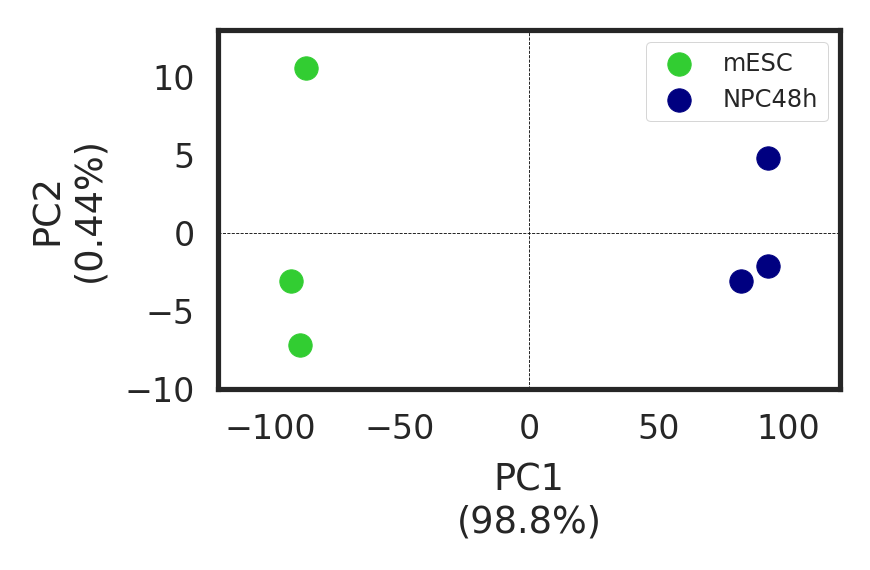

In [2]:
### IMPORT RLOG MATRIX ###
rlog = pd.read_csv("../INTERMEDIATE_FILES/RLD_NPC48h_mESC.tsv",sep="\t")

### select 500 most variable genes ###
top_var = rlog.var(axis=1).sort_values(ascending=False)[1:501].index
rlog = rlog.loc[top_var].T

### PERFORM PCA ###
pca = PCA()
pca_data = pca.fit_transform(rlog)

labels = ["PC{}".format(i) for i in range(pca_data.shape[1]+1)[1:]]
pca_df = pd.DataFrame(pca_data, index = ["mESC_1","mESC_2","mESC_3","NPC48h_1","NPC48h_2","NPC48h_3"], columns=labels)


### PLOT PCA AND SAVE ###
fig,ax=plt.subplots(dpi=300, figsize=(3,2))

plt.scatter(pca_df.filter(regex="^mESC", axis=0)["PC1"], pca_df.filter(regex="^mESC", axis=0)["PC2"], color="limegreen", label = "mESC")
plt.scatter(pca_df.filter(regex="^NPC", axis=0)["PC1"], pca_df.filter(regex="^NPC", axis=0)["PC2"], color="navy", label = "NPC48h")

ax.set_xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
ax.set_ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))

ax.set_ylim(-10,13)
ax.set_xlim(-120,120)

plt.axhline(0,linestyle="--",linewidth=0.2, color="k")
plt.axvline(0,linestyle="--",linewidth=0.2, color="k")

plt.legend(fontsize='xx-small', frameon=True)

plt.tight_layout()

plt.savefig("../FIGURES/PCA_mESC_NPC48h.pdf")

# Visualize differential expression analysis and visualize expression changes of epigenetic enzymes regulating H3K27ac and H3K79me2

In [3]:
### IMPORT EPIGENETIC ENZYMES REFERENCE LIST ###
epigenes = pd.read_csv("../INPUT_DATA/EpiGenes_main.csv",sep=",")

acetyltransferase=list(epigenes.loc[epigenes['Comment'].str.contains('acetyltransferase')]["MGI_symbol"].values)
deacetylase=list(epigenes.loc[epigenes['Comment'].str.contains('deacetylase')]["MGI_symbol"].values)
dot1l = list(epigenes.loc[epigenes["MGI_symbol"].str.contains('Dot1l')]["MGI_symbol"].values)

### SELECT TARGET SET ###
epigenes = ['Hdac10','Hdac11','Hdac2', 'Hdac3', 'Hdac4', 'Hdac7', 'Hdac8', 'Hdac9','Hdac5','Sin3a', 'Hdac6','Sin3b','Sirt2', 'Sirt6', 'Dot1l',
           'Ep300','Hat1', 'Kat2b', 'Kat6a', 'Kat6b', 'Kat7','Kat8','Taf1', 'Taf5', 'Taf7']

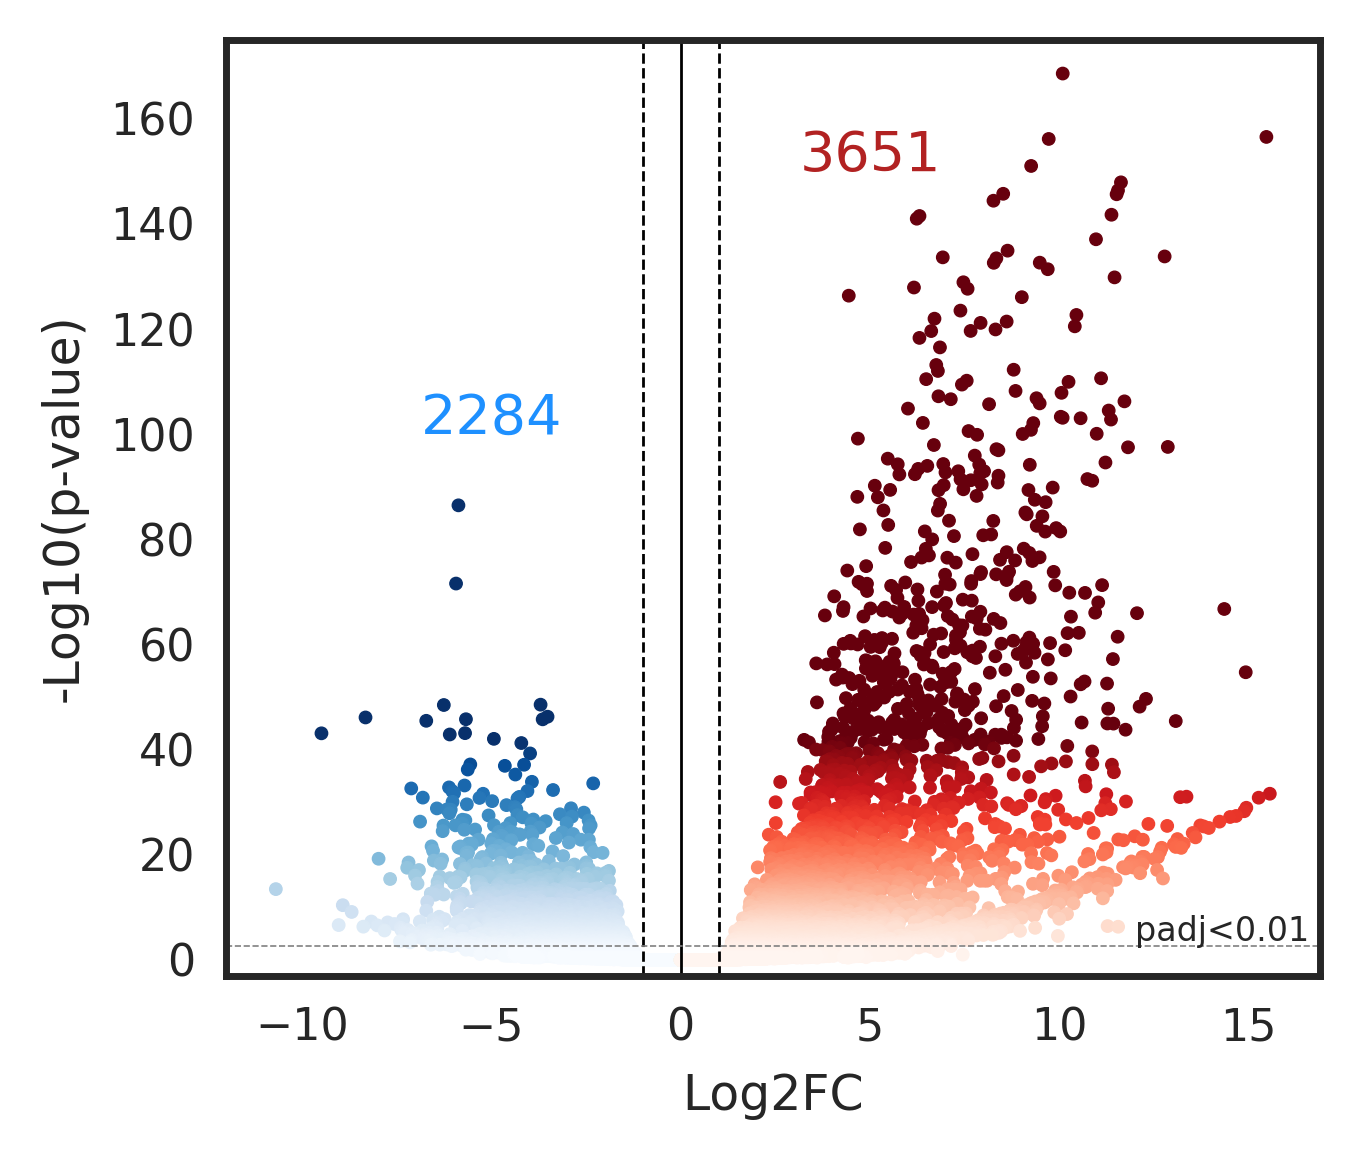

In [6]:
### PLOT ###

### PARAMETERS ###
pval_thr = 0.01
padj_thr = 0.01

### IMPORT DIFFERENTIAL EXPRESSION REFERENCE TABLE ###
npc = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv", sep="\t")

### CREATE EPIGENES DATAFRAME ###
# epi_npc = npc.loc[[i in epigenes for i in npc.symbol]].sort_values(by=["pvalue"], ascending=True)
# epi_npc = npc.loc[[i in epigenes for i in npc.symbol]].sort_values(by=["pvalue"], ascending=True)
# epi_npc["classification"] = ["HAT"]*2+["HDAC"]*5+["HAT","HDAC","DOT1L",'HAT','HDAC','HAT']+['HDAC']*4+["HAT"]*2+["HDAC"]*2+["HAT"]*3+["HDAC"]



### PLOT ####
fig,ax=plt.subplots(dpi=400,figsize=(3.5,3))

npc["minLogPval"] = -np.log10(npc.pvalue)
npc["minLogPadj"] = -np.log10(npc.padj)

npc_up = npc.loc[npc.log2FoldChange>0]
npc_down = npc.loc[npc.log2FoldChange<0]

ax.set_ylim(-3,175)

up = (npc.padj < pval_thr) & (npc.log2FoldChange > 0)
down = (npc.padj < pval_thr) & (npc.log2FoldChange < 0)

ax.annotate(sum(up), (5,150), color="firebrick", size=10, ha='center')
ax.annotate(sum(down), (-5,100), color="dodgerblue", size=10, ha='center')

### map downregulated genes colorcode ###
minima = 0
maxima = 40
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
mapper.set_array(npc_down.minLogPadj)
rgba_list=[]
for v in npc_down["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))
ax.scatter(npc_down.log2FoldChange, npc_down.minLogPval,s=5,c=rgba_list)

### map upregulated genes colorcode ###
minima = 0
maxima = 40
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
mapper.set_array(npc_up.minLogPadj)
rgba_list=[]
for v in npc_up["minLogPadj"]:
            rgba_list.append(mapper.to_rgba(v))

ax.scatter(npc_up.log2FoldChange, npc_up.minLogPval,s=5,c=rgba_list)

ax.axvline(0,linestyle='-',linewidth=0.5,color='k')
ax.axvline(-1,linestyle='--',linewidth=0.5,color='k')
ax.axvline(1,linestyle='--',linewidth=0.5,color='k')

# idx_HAT = epi_npc.loc[(epi_npc.padj<padj_thr) & (epi_npc.classification == "HAT")].index
# idx_HDAC = epi_npc.loc[(epi_npc.padj<padj_thr) & (epi_npc.classification == "HDAC")].index
# idx_DOT = epi_npc.loc[epi_npc.classification == "DOT1L"].index


# ax.scatter(npc.loc[idx_HAT]["log2FoldChange"], npc.loc[idx_HAT]["minLogPval"],s=12,edgecolor='k', marker="^", facecolor="None", label = "HAT")
# ax.scatter(npc.loc[idx_HDAC]["log2FoldChange"], npc.loc[idx_HDAC]["minLogPval"],s=12,edgecolor='k', marker="v", facecolor="None", label="HDAC")
# ax.scatter(npc.loc[idx_DOT]["log2FoldChange"], npc.loc[idx_DOT]["minLogPval"],s=12, edgecolor='k', marker="o", facecolor="None", label="Dot1l")


pval_thr = -np.log10(npc.loc[npc.padj<padj_thr].tail(n=1)["pvalue"].values[0])
ax.axhline(pval_thr,linestyle='--',linewidth=0.3,color='grey')
ax.annotate("padj<{}".format(padj_thr),[12,pval_thr+1],size=6)
ax.set_ylabel("-Log10(p-value)")
ax.set_xlabel("Log2FC")

# plt.legend(fontsize="x-small")
plt.tight_layout()

plt.savefig("../FIGURES/Volcano_NPC48hVSmESC.png")